In [ ]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/TelcoCustomerChurn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [ ]:
#Step 1: Drop the customerID, not important for our project
df.drop('customerID', axis=1, inplace=True)

# Step 2: Convert TotalCharges to numeric and handle missing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Step 3: Fill service-related NaNs with 'No'
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

df[service_cols] = df[service_cols].fillna('No')

# Step 4: Encode binary categorical variables
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'Churn']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Gender encoding
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Step 5: One-hot encode multi-category features
multi_cat_cols = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# Step 6: Create tenure_group (optional)
df['tenure_group'] = pd.cut(df['tenure'],
                            bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '13-24', '25-48', '49-60', '61-72'])

df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

In [ ]:
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Fill with '0'
df[service_cols] = df[service_cols].fillna(0)

In [ ]:
# Step 7: Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Step 8: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Identify numeric columns to scale
scale_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize scaler
scaler = StandardScaler()

# Fit-transform only on training data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])


In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[932 101]
 [195 179]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



📊 Interpretation

Accuracy (79%) looks decent, but this dataset is imbalanced (much more “no churn” than “churn”), so accuracy is misleading.

Class 0 (No Churn) performs well — high recall (0.90) means the model correctly identifies most non-churn customers.

Class 1 (Churn) performs poorly — recall is only 0.48, meaning the model misses more than half of the churned customers.

Precision for churn (0.64) is okay, but since recall is low, it suggests your model is biased toward predicting “no churn”.

Macro avg (0.71) shows an overall moderate balance between both classes, but the gap between classes indicates the model struggles with the minority class.

⚠️ Conclusion

The linear regression model is not well-suited for churn classification — it treats the problem as continuous rather than categorical.

It’s overfitting toward the majority class (no churn).

Getting many false negatives (failing to predict real churners).

In [ ]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[732 301]
 [ 74 300]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.80      0.62       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.71      1407
weighted avg       0.80      0.73      0.75      1407



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'),
                    param_grid, cv=5, scoring='f1')
grid.fit(X_train_scaled, y_train)

print(grid.best_params_)


{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.01, solver='lbfgs', penalty='l2')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[753 280]
 [ 88 286]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1033
           1       0.51      0.76      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.75      1407



In [ ]:
# Get feature names (assuming you have them in X_train)
feature_names = X_train_scaled.columns

# Get coefficients from the model
coefficients = model.coef_[0]

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))  # Top 10 most important features

                           Feature  Coefficient  Importance
4                           tenure    -0.715093    0.715093
20               Contract_Two year    -0.567517    0.567517
13                  MonthlyCharges     0.459544    0.459544
17     InternetService_Fiber optic     0.445348    0.445348
19               Contract_One year    -0.389624    0.389624
9                      TechSupport    -0.334289    0.334289
6                   OnlineSecurity    -0.328455    0.328455
18              InternetService_No    -0.320470    0.320470
22  PaymentMethod_Electronic check     0.311794    0.311794
24              tenure_group_13-24    -0.277864    0.277864


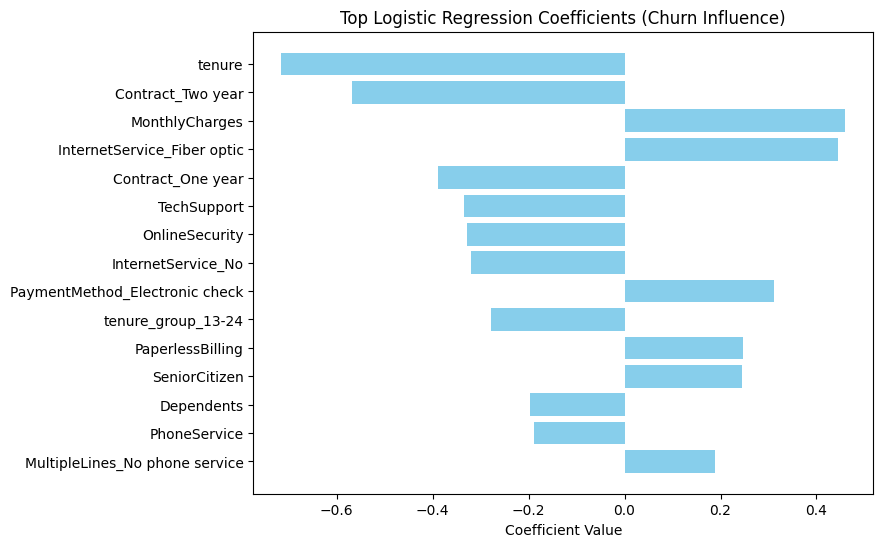

In [ ]:
top_features = importance_df.head(15)  # top 15 for visualization

plt.figure(figsize=(8,6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top Logistic Regression Coefficients (Churn Influence)')
plt.gca().invert_yaxis()
plt.show()

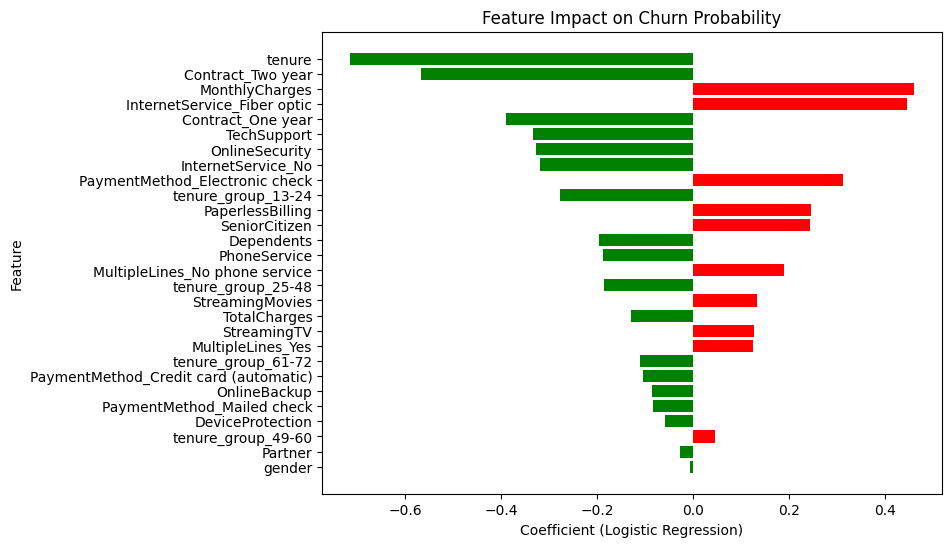

In [ ]:
plt.figure(figsize=(8,6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color=importance_df['Coefficient'].apply(lambda x: 'red' if x > 0 else 'green'))
plt.title('Feature Impact on Churn Probability')
plt.xlabel('Coefficient (Logistic Regression)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

🟩 Green = Retention features
🟥 Red = Churn risk features